In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression





## Load Datasets

In [2]:
gse7390 = pd.read_excel('GSE7390_Clean.xlsx', index_col = 0)
gse7390_532Genes = pd.read_csv('GSE7390_New_df.csv')

In [3]:
target = gse7390['phenotype']
features = gse7390.drop(['phenotype', 'time'], axis=1)

In [4]:
print(features.head())

             DDR1 /// MIR4640     RFC2    HSPA6     PAX8    GUCA1A  \
Gene Symbol                                                          
GSM177885             10781.0  86742.0  77386.0  92855.0  66105.00   
GSM177886             11335.0  93548.0   7764.0  90258.0  48099.00   
GSM177887             11028.0  90539.0  63276.0  92344.0     46.22   
GSM177888             11848.0  91399.0  70326.0  96564.0   5589.00   
GSM177889             12359.0  91967.0  78734.0  91742.0  53252.00   

             MIR5193 /// UBA7     THRA   PTPN21     CCL5    CYP2E1  ...  \
Gene Symbol                                                         ...   
GSM177885             85052.0  68672.0  71682.0  62527.0  52625.00  ...   
GSM177886             86746.0  50977.0  56543.0  98927.0     34.39  ...   
GSM177887             84068.0   6932.0  62635.0  87771.0     47.38  ...   
GSM177888             91064.0  77511.0  63717.0  11993.0  51851.00  ...   
GSM177889             10031.0  71568.0  40578.0  63595.0  6

## Boruta on 532 genes

In [5]:
importance_df = pd.read_csv('importance_score_gse7390.csv')
print(importance_df.head())

  Unnamed: 0   meanImp  medianImp    minImp    maxImp  normHits  decision
0       CTSG -0.147764  -0.163210 -1.599140  1.415349       0.0  Rejected
1       BBS1  0.141467  -0.048230 -1.415564  1.628482       0.0  Rejected
2   SERPINH1 -0.394702  -0.486302 -1.913311  1.035559       0.0  Rejected
3      CCNB1 -0.518729  -0.500312 -2.006333  1.251611       0.0  Rejected
4      HIF1A  0.116083  -0.046587 -1.223683  2.482973       0.0  Rejected


In [6]:
# sort in descending order by mean_importance
importance_df = importance_df.sort_values(by='meanImp', ascending=False)
# get top 80 features
top_features = importance_df['Unnamed: 0'][:80]
top_features = top_features.tolist()
# write top features into excel file
top_features_df = pd.DataFrame(top_features)
top_features_df.to_excel('boruta_top_features.xlsx', index=False)
top_features.append('phenotype')



In [7]:
gse7390_top = gse7390_532Genes[top_features]

In [8]:
target_boruta = gse7390_top['phenotype']
features_boruta = gse7390_top.drop('phenotype', axis=1)

In [9]:
# run random forest
X_train_boruta, X_test_boruta, y_train_boruta, y_test_boruta = train_test_split(features_boruta, target_boruta, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_boruta = scaler.fit_transform(X_train_boruta)
X_test_boruta = scaler.transform(X_test_boruta)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_boruta, y_train_boruta)
y_pred_boruta = rf.predict(X_test_boruta)
accuracy = accuracy_score(y_test_boruta, y_pred_boruta)
print('Accuracy:', accuracy)



Accuracy: 0.65


In [10]:
accuracy_list_boruta = []
for i in range(100):
    X_train_boruta, X_test_boruta, y_train_boruta, y_test_boruta = train_test_split(features_boruta, target_boruta, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_boruta = scaler.fit_transform(X_train_boruta)
    X_test_boruta = scaler.transform(X_test_boruta)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_boruta, y_train_boruta)
    y_pred_boruta = rf.predict(X_test_boruta)
    accuracy = accuracy_score(y_test_boruta, y_pred_boruta)
    accuracy_list_boruta.append(accuracy)

## SPS and Hub61

In [11]:
signatures = pd.read_excel('signatures.xlsx')
print(signatures.head())
SPS_genes = signatures['SPS']
sps_genes_in_dataset = []
sps_genes_in_dataset.append('phenotype')
for gene in SPS_genes:
    if gene in gse7390.columns:
        sps_genes_in_dataset.append(gene)

gse7390_sps = gse7390[sps_genes_in_dataset]
print(sps_genes_in_dataset.__len__())

     SPS   PAM50   MammaPrint OncotypeDX     HUB61 FWSE GSE7390  \
0  ATAD2  ACTR3B  AA555029_RC       ACTB      BUB1        CSRP2   
1  AURKA    ANLN      ALDH4A1      AURKA     UBE2C         UBL3   
2  AURKB    BAG1        AP2B1       BAG1   DEPDC1B         KLF6   
3  BIRC5    BCL2        AYTL2       BCL2       BLM      MRPS18B   
4  BRCA1   BIRC5         BBC3      BIRC5  C6orf173        SPTA1   

  Boruta GSE7390 Boruta GSE202203 FWSE GSE202203  
0          PDS5B             GMNN          GTSE1  
1           PLK1           CHAF1B           LYL1  
2          RBBP4             HMBS         TMEFF1  
3          FOXM1            KIF2C          CENPL  
4          KIF4A             DHFR           HMBS  
81


In [12]:
target_sps = gse7390_sps['phenotype']
features_sps = gse7390_sps.drop(['phenotype'], axis=1)

In [13]:
hub61_genes_in_dataset = []
# add phenotype to hub61_genes_in_dataset
hub61_genes_in_dataset.append('phenotype')
hub61_genes = signatures['HUB61']
for gene in hub61_genes:
    if gene in gse7390.columns:
        hub61_genes_in_dataset.append(gene)

gse7390_hub61 = gse7390[hub61_genes_in_dataset]
print(hub61_genes_in_dataset.__len__())



53


In [14]:
target_hub61 = gse7390_hub61['phenotype']
features_hub61 = gse7390_hub61.drop(['phenotype'], axis=1)

In [15]:
# run random forest
X_train_sps, X_test_sps, y_train_sps, y_test_sps = train_test_split(features_sps, target_sps, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sps = scaler.fit_transform(X_train_sps)
X_test_sps = scaler.transform(X_test_sps)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sps, y_train_sps)
y_pred_sps = rf.predict(X_test_sps)
print(accuracy_score(y_test_sps, y_pred_sps))

0.65


In [16]:
# run random forest 100 times
accuracy_list_sps = []
for i in range(100):
    X_train_sps, X_test_sps, y_train_sps, y_test_sps = train_test_split(features_sps, target_sps, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_sps = scaler.fit_transform(X_train_sps)
    X_test_sps = scaler.transform(X_test_sps)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_sps, y_train_sps)
    y_pred_sps = rf.predict(X_test_sps)
    accuracy = accuracy_score(y_test_sps, y_pred_sps)
    accuracy_list_sps.append(accuracy)

In [17]:
X_train_hub61, X_test_hub61, y_train_hub61, y_test_hub61 = train_test_split(features_hub61, target_hub61, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_hub61 = scaler.fit_transform(X_train_hub61)
X_test_hub61 = scaler.transform(X_test_hub61)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_hub61, y_train_hub61)
y_pred_hub61 = rf.predict(X_test_hub61)
print(accuracy_score(y_test_hub61, y_pred_hub61))


0.675


In [18]:
accuracy_list_hub61 = []
for i in range(100):
    X_train_hub61, X_test_hub61, y_train_hub61, y_test_hub61 = train_test_split(features_hub61, target_hub61, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_hub61 = scaler.fit_transform(X_train_hub61)
    X_test_hub61 = scaler.transform(X_test_hub61)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_hub61, y_train_hub61)
    y_pred_hub61 = rf.predict(X_test_hub61)
    accuracy = accuracy_score(y_test_hub61, y_pred_hub61)
    accuracy_list_hub61.append(accuracy)

## Random

In [19]:
# Get 80 random genes from gse7390
random_genes = np.random.choice(gse7390.columns, 80, replace=False)
random_genes = random_genes.tolist()
random_genes.append('phenotype')

gse7390_random = gse7390[random_genes]

In [20]:
features_random = gse7390_random.drop(['phenotype'], axis=1)
target_random = gse7390_random['phenotype']


In [21]:
X_train_random , X_test_random, y_train_random, y_test_random = train_test_split(features_random, target_random, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_random = scaler.fit_transform(X_train_random)
X_test_random = scaler.transform(X_test_random)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_random, y_train_random)
y_pred_random = rf.predict(X_test_random)
print(accuracy_score(y_test_random, y_pred_random))

0.65


In [22]:
# find number of random genes in boruta genes
count_boruta = 0
for gene in random_genes:
    if gene in top_features:
        count_boruta += 1
print(count_boruta)

count_sps = 0
for gene in random_genes:
    if gene in sps_genes_in_dataset:
        count_sps += 1
print(count_sps)

1
1


## Random from 532

In [23]:
random_532 = np.random.choice(gse7390_532Genes.columns, 80, replace=False)
random_532 = random_532.tolist()
random_532.append('phenotype')

gse7390_random_532 = gse7390_532Genes[random_532]


In [24]:
count_boruta_532 = 0
for gene in random_532:
    if gene in top_features:
        count_boruta_532 += 1
print(count_boruta_532)

count_sps_532 = 0
for gene in random_532:
    if gene in sps_genes_in_dataset:
        count_sps_532 += 1
print(count_sps_532)

17
16


In [25]:
features_random_532 = gse7390_random_532.drop(['phenotype'], axis=1)
target_random_532 = gse7390_random_532['phenotype']


In [26]:
X_train_random_532 , X_test_random_532, y_train_random_532, y_test_random_532 = train_test_split(features_random_532, target_random_532, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_random_532 = scaler.fit_transform(X_train_random_532)
X_test_random_532 = scaler.transform(X_test_random_532)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_random_532, y_train_random_532)
y_pred_random_532 = rf.predict(X_test_random_532)
print(accuracy_score(y_test_random_532, y_pred_random_532))


0.675


In [27]:
accuracy_list_random = []
for i in range(100):
    random_genes = np.random.choice(gse7390.columns, 80, replace=False)
    random_genes = random_genes.tolist()
    random_genes.append('phenotype')
    features_random = gse7390_random.drop(['phenotype'], axis=1)
    target_random = gse7390_random['phenotype']

    gse7390_random = gse7390[random_genes]
    X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(features_random, target_random, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_random = scaler.fit_transform(X_train_random)
    X_test_random = scaler.transform(X_test_random)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_random, y_train_random)
    y_pred_random = rf.predict(X_test_random)
    accuracy = accuracy_score(y_test_random, y_pred_random)
    accuracy_list_random.append(accuracy)

In [46]:
    random_532 = np.random.choice(gse7390_532Genes.columns, 80, replace=False)
    random_532 = random_532.tolist()
    random_532.append('phenotype')

    gse7390_random_532 = gse7390_532Genes[random_532]
    features_random_532 = gse7390_random_532.drop(['phenotype'], axis=1)
    target_random_532 = gse7390_random_532['phenotype']

In [47]:
accuracy_list_random_532 = []
for i in range(100):

    X_train_random_532, X_test_random_532, y_train_random_532, y_test_random_532 = train_test_split(features_random_532, target_random_532, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_random_532 = scaler.fit_transform(X_train_random_532)
    X_test_random_532 = scaler.transform(X_test_random_532)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_random_532, y_train_random_532)
    y_pred_random_532 = rf.predict(X_test_random_532)
    accuracy = accuracy_score(y_test_random_532, y_pred_random_532)
    accuracy_list_random_532.append(accuracy)

## FWSE

In [29]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample

class FWSE(BaseEstimator, TransformerMixin):
    def __init__(self, filter_estimators, wrapper_estimators, n_bootstraps=10, random_state=0):
        self.filter_estimators = filter_estimators
        self.wrapper_estimators = wrapper_estimators
        self.n_bootstraps = n_bootstraps
        self.random_state = random_state
        self.feature_ranking_ = None

    def fit(self, X, y):
        
        filter_rankings = []
            
        for estimator in self.filter_estimators:

            estimator_rankings = []
        
            for _ in range(self.n_bootstraps):           
                
                X_bootstrapped, y_bootstrapped = resample(X, y, random_state=self.random_state)
                fitted_estimator = estimator.fit(X_bootstrapped, y_bootstrapped)

                if hasattr(fitted_estimator, 'coef_'):
                    bootstrap_importances = fitted_estimator.coef_.flatten()
                    bootstrap_ranking = np.argsort(np.argsort(-1*bootstrap_importances))

                elif hasattr(fitted_estimator, 'feature_importances_'):
                    bootstrap_importances = fitted_estimator.feature_importances_
                    bootstrap_ranking = np.argsort(np.argsort(-1*bootstrap_importances))

                elif hasattr(fitted_estimator, 'ranking_'):
                    bootstrap_ranking = fitted_estimator.ranking_
        
                estimator_rankings.append(bootstrap_ranking)

            filter_rankings.append(self.aggregate_rankings(estimator_rankings))
        
        aggregated_ranking_filter = self.aggregate_rankings(filter_rankings)
        filtered_features = np.argsort(aggregated_ranking_filter)[:len(aggregated_ranking_filter) // 2]

        wrapper_rankings = []
            
        for estimator in self.wrapper_estimators:

            estimator_rankings = []
        
            for _ in range(self.n_bootstraps):           
                
                X_bootstrapped, y_bootstrapped = resample(X[:, filtered_features], y, random_state=self.random_state)
                fitted_estimator = estimator.fit(X_bootstrapped, y_bootstrapped)

                if hasattr(fitted_estimator, 'coef_'):
                    bootstrap_importances = fitted_estimator.coef_.flatten()
                    bootstrap_ranking = np.argsort(np.argsort(-1*bootstrap_importances))

                elif hasattr(fitted_estimator, 'feature_importances_'):
                    bootstrap_importances = fitted_estimator.feature_importances_
                    bootstrap_ranking = np.argsort(np.argsort(-1*bootstrap_importances))

                elif hasattr(fitted_estimator, 'ranking_'):
                    bootstrap_ranking = fitted_estimator.ranking_

                estimator_rankings.append(bootstrap_ranking)

            wrapper_rankings.append(self.aggregate_rankings(estimator_rankings))
            
        aggregated_ranking_wrapper = self.aggregate_rankings(wrapper_rankings)
        final_ranking = np.array(filtered_features[np.argsort(aggregated_ranking_wrapper)].tolist() + aggregated_ranking_filter[len(aggregated_ranking_filter) // 2:].tolist())
        self.feature_ranking_ = final_ranking 

        return self

    def transform(self, X):
        if self.feature_ranking_ is None:
            raise ValueError("FWSE has not been fitted yet.")
        return X[:, self.feature_ranking_]

    def aggregate_rankings(self, rankings):
        aggregate_ranking = np.argsort(np.argsort(np.sum(rankings, axis=0)))
        return aggregate_ranking

In [30]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(gse7390_532Genes, target, test_size=0.2, random_state=0)

filter_estimators = [RandomForestClassifier(n_estimators=100, random_state=0)]
wrapper_estimators = [LogisticRegression(max_iter=1000, random_state=0)]

fwse_new = FWSE(filter_estimators, wrapper_estimators, n_bootstraps=10, random_state=0)

fwse_new.fit(X_train_new.values, y_train_new.values)
X_train_selected_new = fwse_new.transform(X_train_new.values)

selected_features_new = gse7390_532Genes.columns[fwse_new.feature_ranking_]
selected_features_new = selected_features_new[:80]

In [31]:
selected_features_new = selected_features_new.tolist()
selected_features_df = pd.DataFrame(selected_features_new)
selected_features_df.to_excel('fwse_selected_features.xlsx', index=False)
selected_features_new.append('phenotype')

In [32]:
gse7390_fwse = gse7390_532Genes[selected_features_new]
print(gse7390_fwse.head())

     CSRP2     UBL3     KLF6  MRPS18B     SPTA1      SKP2      MCM4   NT5DC2  \
0  10983.0  10237.0  99143.0  97638.0  33773.00  90147.00  93557.00  88162.0   
1  71528.0  10361.0  86845.0  10251.0  58887.00   1065.00  88816.00  91627.0   
2  10747.0  90127.0   1056.0  10488.0     32.23  98959.00  96135.00  10239.0   
3  77914.0  89354.0  95426.0  11017.0  60436.00  85877.00  95665.00  84812.0   
4  86316.0  83275.0  10046.0  96666.0  69806.00     78.83     86.53  85399.0   

     CCNB2      TFF3  ...     GYPA      NFE2    IFT88    LARP1   RPL27A  \
0  99029.0  75689.00  ...      0.0  35848.00  78953.0  88488.0  10556.0   
1  10396.0  11726.00  ...      0.0  55207.00  81629.0  88618.0  94215.0   
2     10.0   7278.00  ...      0.0  35947.00  78416.0  89572.0  10888.0   
3  10559.0     11.21  ...  43712.0      5.32  84671.0  99212.0  10296.0   
4  91531.0  13981.00  ...   1478.0  48545.00  85778.0   9573.0  10065.0   

      PARP1     BDH2     POLQ   RUVBL1  phenotype  
0     10.49  107

In [33]:
target_fwse = gse7390_fwse['phenotype']
features_fwse = gse7390_fwse.drop(['phenotype'], axis=1)


In [34]:
X_train_fwse, X_test_fwse, y_train_fwse, y_test_fwse = train_test_split(features_fwse, target_fwse, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_fwse = scaler.fit_transform(X_train_fwse)
X_test_fwse = scaler.transform(X_test_fwse)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fwse, y_train_fwse)
y_pred_fwse = rf.predict(X_test_fwse)
print(accuracy_score(y_test_fwse, y_pred_fwse))

0.65


In [35]:
# run random forest 100 times
accuracy_list_fwse = []
for i in range(100):
    X_train_fwse, X_test_fwse, y_train_fwse, y_test_fwse = train_test_split(features_fwse, target_fwse, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_fwse = scaler.fit_transform(X_train_fwse)
    X_test_fwse = scaler.transform(X_test_fwse)

    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train_fwse, y_train_fwse)
    y_pred_fwse = rf.predict(X_test_fwse)
    accuracy = accuracy_score(y_test_fwse, y_pred_fwse)
    accuracy_list_fwse.append(accuracy)
    

In [48]:
results_df = pd.DataFrame(
    {
        'Boruta': accuracy_list_boruta,
        'SPS': accuracy_list_sps,
        'Random \n (dataset)': accuracy_list_random,
        'Random \n (532)': accuracy_list_random_532,
        "FWSE": accuracy_list_fwse
    }
)

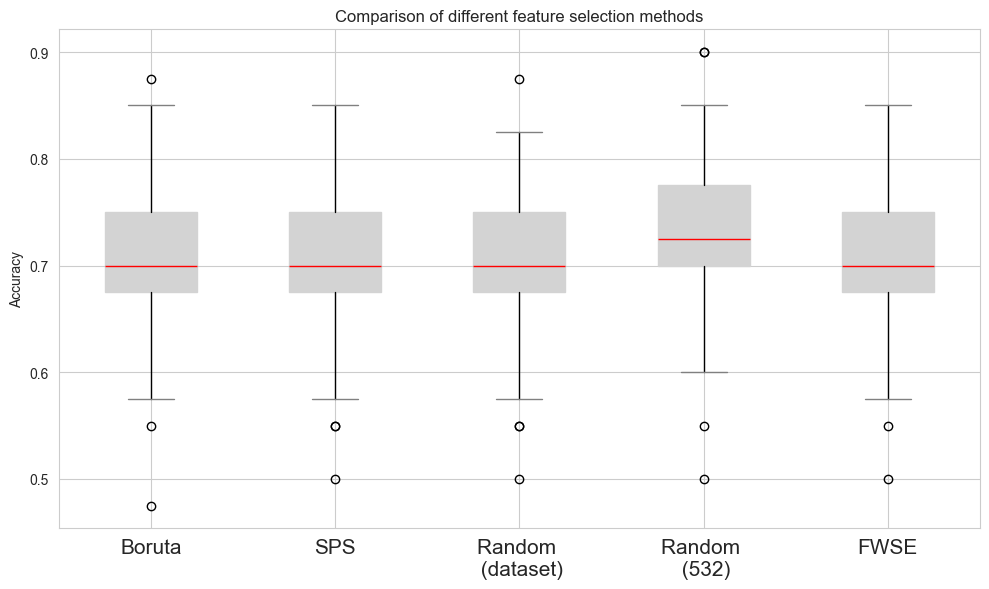

In [83]:
plt.figure(figsize=(10, 6), dpi=100)
color = dict(
    boxes='lightgrey',
    whiskers='black',
    medians='Red',
    caps='Gray'
)
results_df.boxplot(patch_artist=True, color=color, showmeans=False)

plt.ylabel('Accuracy')
plt.title('Comparison of different feature selection methods')
# change x axis labels font size
plt.xticks(fontsize=15)
plt.tight_layout()

plt.show()




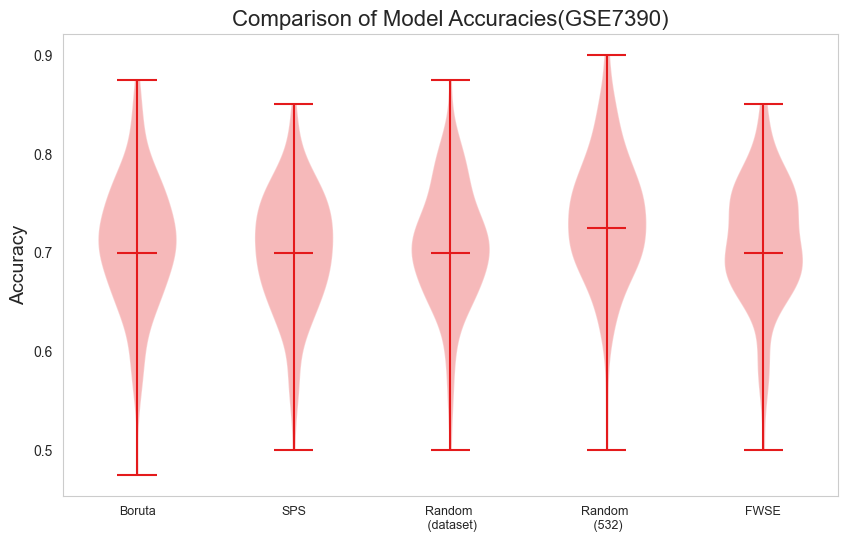

In [65]:
# violin plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a violin plot
plt.violinplot(results_df.values, showmedians=True)

# Add labels and title
plt.xticks([1, 2, 3, 4, 5], results_df.columns, fontsize=9)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Model Accuracies(GSE7390)', fontsize=16)

# Show the plot
plt.show()

<Figure size 1500x200 with 0 Axes>

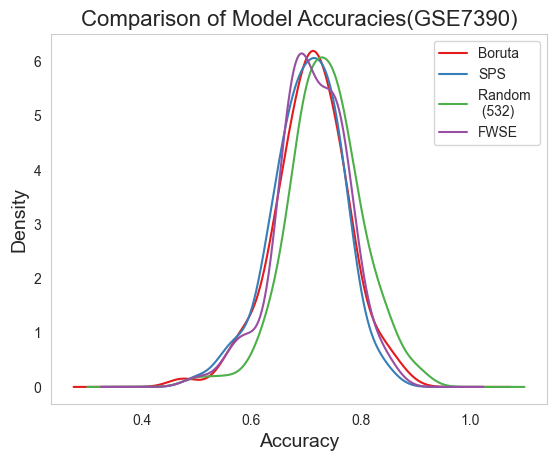

In [84]:
# density plot
plt.figure(figsize=(15,2))  # Set the figure size
# remove the 'Random (dataset)' column
results_df = results_df.drop('Random \n (dataset)', axis=1)
results_df.plot(kind='density')  # Create a density plot

plt.title('Comparison of Model Accuracies(GSE7390)', fontsize=16)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Accuracy', fontsize=14)
plt.show()

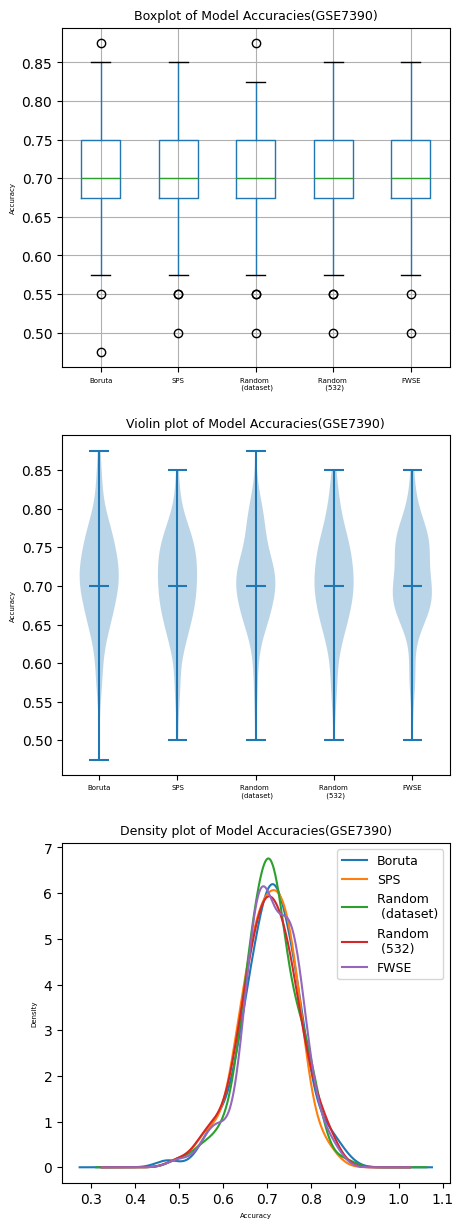

In [40]:
# plot all boxplot, violin plot and desnity plot in one figure
fig, axs = plt.subplots(3,1, figsize=(5,15))

# Boxplot
results_df.boxplot(ax=axs[0])
axs[0].set_ylabel('Accuracy', fontsize=5)
axs[0].set_title('Boxplot of Model Accuracies(GSE7390)', fontsize=9)
axs[0].set_xticks([1, 2, 3, 4, 5])
axs[0].set_xticklabels(results_df.columns, fontsize=5)

# Violin plot
axs[1].violinplot(results_df.values, showmedians=True)
axs[1].set_xticks([1, 2, 3, 4, 5])
axs[1].set_xticklabels(results_df.columns, fontsize=5)
axs[1].set_ylabel('Accuracy', fontsize=5)
axs[1].set_title('Violin plot of Model Accuracies(GSE7390)', fontsize=9)

# Density plot
results_df.plot(kind='density', ax=axs[2])
axs[2].set_title('Density plot of Model Accuracies(GSE7390)', fontsize=9)
axs[2].set_ylabel('Density', fontsize=5)
axs[2].set_xlabel('Accuracy', fontsize=5)
axs[2].legend(fontsize=9)

plt.show()

In [41]:
import pandas as pd

signature_all_boruta = pd.read_csv("importance_score_gse7390_all.csv", header = 0 )
print(signature_all_boruta.columns)

Index(['Unnamed: 0', 'meanImp', 'medianImp', 'minImp', 'maxImp', 'normHits',
       'decision'],
      dtype='object')


In [42]:
# sort by mean importance, highest first
signature_all_boruta = signature_all_boruta.sort_values(by='meanImp', ascending=False)

# get top 80 features
top_features_all_boruta = signature_all_boruta['Unnamed: 0'][:80]
# top_features_all_boruta = top_features_all_boruta.tolist()
top_features_all_boruta.to_excel('boruta_top_features_all_15runs.xlsx', index=False)